# PDSCH : Simulation 

Jayakumar. S Ph.D </br>
04/01/24

In [11]:
import numpy as np
from scipy.constants import speed_of_light
from math import floor
from scipy.fft import fft
from math import ceil
from scipy.io import loadmat
import scipy.stats
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
# Create simParameters structure to contain all key simulation parameters
simParameters = {}

# Simulation length, transmitter, and receiver configuration
simParameters['NFrames'] = 2
simParameters['TxPower'] = list(range(60, 66))
simParameters['RxNoiseFigure'] = 6
simParameters['RxAntennaTemperature'] = 290
simParameters['DopplerPreCompensator'] = True
simParameters['PreCompensationDopplerShift'] = None
simParameters['RxDopplerCompensator'] = False
simParameters['RxDopplerCompensationMethod'] = 'independent time-freq'
simParameters['FrequencyRange'] = [-50e3, 50e3]
simParameters['FrequencyResolution'] = 1e3
simParameters['InitialTimingSynchronization'] = 'joint time-freq'
simParameters['InitialFrequencyRange'] = [-50e3, 50e3]
simParameters['InitialFrequencyResolution'] = 1e3

# Carrier and PDSCH Configuration
simParameters['Carrier'] = {
    'SubcarrierSpacing': 30,
    'CyclicPrefix': 'Normal',
    'NSizeGrid': 11,
    'NCellID': 1
}

simParameters['PDSCH'] = {
    'PRBSet': list(range(0, 11)),
    'SymbolAllocation': [0, 14],
    'MappingType': 'A',
    'NumLayers': 1,
    'ModulationScheme': '16QAM',
    'DMRS': {
        'DMRSPortSet': list(range(0, 1)),
        'DMRSTypeAPosition': 2,
        'DMRSLength': 1,
        'DMRSAdditionalPosition': 2,
        'DMRSConfigurationType': 2,
        'NumCDMGroupsWithoutData': 1,
        'NIDNSCID': 1,
        'NSCID': 0
    },
    'EnablePTRS': 0,
    'PTRS': {
        'TimeDensity': 1,
        'FrequencyDensity': 2,
        'REOffset': '00',
        'PTRSPortSet': []
    }
}

simParameters['PDSCHExtension'] = {
    'PRGBundleSize': None,
    'XOverhead': 6 * 0,
    'NHARQProcesses': 1,
    'EnableHARQ': False,
    'LDPCDecodingAlgorithm': 'Normalized min-sum',
    'MaximumLDPCIterationCount': 6
}

simParameters['NumTransmitAntennas'] = 1
simParameters['NumReceiveAntennas'] = 8 if simParameters['PDSCH']['NumLayers'] > 4 else 1
simParameters['DataType'] = 'double'

# Display the parameters
print(simParameters)

{'NFrames': 2, 'TxPower': [60, 61, 62, 63, 64, 65], 'RxNoiseFigure': 6, 'RxAntennaTemperature': 290, 'DopplerPreCompensator': True, 'PreCompensationDopplerShift': None, 'RxDopplerCompensator': False, 'RxDopplerCompensationMethod': 'independent time-freq', 'FrequencyRange': [-50000.0, 50000.0], 'FrequencyResolution': 1000.0, 'InitialTimingSynchronization': 'joint time-freq', 'InitialFrequencyRange': [-50000.0, 50000.0], 'InitialFrequencyResolution': 1000.0, 'Carrier': {'SubcarrierSpacing': 30, 'CyclicPrefix': 'Normal', 'NSizeGrid': 11, 'NCellID': 1}, 'PDSCH': {'PRBSet': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'SymbolAllocation': [0, 14], 'MappingType': 'A', 'NumLayers': 1, 'ModulationScheme': '16QAM', 'DMRS': {'DMRSPortSet': [0], 'DMRSTypeAPosition': 2, 'DMRSLength': 1, 'DMRSAdditionalPosition': 2, 'DMRSConfigurationType': 2, 'NumCDMGroupsWithoutData': 1, 'NIDNSCID': 1, 'NSCID': 0}, 'EnablePTRS': 0, 'PTRS': {'TimeDensity': 1, 'FrequencyDensity': 2, 'REOffset': '00', 'PTRSPortSet': []}}, 'PD

In [13]:

# Create simParameters structure to contain all key simulation parameters
simParameters = {
    'NFrames': 2,  # Number of 10 ms frames
    'TxPower': list(range(60, 66)),  # Transmit power (dBm)
    'RxNoiseFigure': 6,  # Noise figure (dB)
    'RxAntennaTemperature': 290,  # Antenna temperature (K)
    'DopplerPreCompensator': True,
    'PreCompensationDopplerShift': None,  # In Hz
    'RxDopplerCompensator': False,
    'RxDopplerCompensationMethod': 'independent time-freq',
    'FrequencyRange': [-50e3, 50e3],  # Set the search range of Doppler shift in Hz [MIN,MAX]
    'FrequencyResolution': 1e3,  # Set the search range resolution of Doppler shift in Hz
    'InitialTimingSynchronization': 'joint time-freq',
    'InitialFrequencyRange': [-50e3, 50e3],  # Set the initial search range of Doppler shift in Hz [MIN,MAX]
    'InitialFrequencyResolution': 1e3,  # Set the initial search range resolution of Doppler shift in Hz
    'Carrier': {
        'SubcarrierSpacing': 30,  # Subcarrier spacing in kHz: 15, 30, 60, 120, 240, 480, or 960
        'CyclicPrefix': 'Normal',  # Cyclic prefix length: 'Normal' or 'Extended'
        'NSizeGrid': 11,  # Bandwidth in number of RBs
        'NCellID': 1  # Physical layer cell identity
    },
    'PDSCH': {
        'PRBSet': list(range(0, 11)),  # PDSCH PRB allocation
        'SymbolAllocation': [0, 14],  # Starting symbol and number of symbols of each PDSCH allocation
        'MappingType': 'A',  # PDSCH mapping type ('A' or 'B')
        'NumLayers': 1,  # Number of transmission layers
        'ModulationScheme': '16QAM',  # Modulation scheme: 'QPSK', '16QAM', '64QAM', or '256QAM'
        'DMRS': {
            'DMRSPortSet': list(range(0, 1)),  # DM-RS port set
            'DMRSTypeAPosition': 2,
            'DMRSLength': 1,
            'DMRSAdditionalPosition': 2,
            'DMRSConfigurationType': 2,
            'NumCDMGroupsWithoutData': 1,
            'NIDNSCID': 1,
            'NSCID': 0
        },
        'EnablePTRS': 0,  # PT-RS configuration
        'PTRS': {
            'TimeDensity': 1,
            'FrequencyDensity': 2,
            'REOffset': '00',
            'PTRSPortSet': []
        }
    },
    'PDSCHExtension': {
        'PRGBundleSize': None,  # 2, 4, or None to signify "wideband"
        'XOverhead': 6 * 0,  # PDSCH rate matching overhead for TBS (Xoh)
        'NHARQProcesses': 1,  # Number of parallel HARQ processes
        'EnableHARQ': False,  # Enable retransmissions for each process
        'LDPCDecodingAlgorithm': 'Normalized min-sum',  # LDPC decoder algorithm
        'MaximumLDPCIterationCount': 6  # Maximum LDPC iteration count
    },
    'NumTransmitAntennas': 1,  # Number of PDSCH transmission antennas
    'NumReceiveAntennas': 8 if simParameters['PDSCH']['NumLayers'] > 4 else 1,  # Number of UE receive antennas
    'DataType': 'double'  # Define data type for resource grids and waveforms
}

# Display the parameters
print(simParameters)

{'NFrames': 2, 'TxPower': [60, 61, 62, 63, 64, 65], 'RxNoiseFigure': 6, 'RxAntennaTemperature': 290, 'DopplerPreCompensator': True, 'PreCompensationDopplerShift': None, 'RxDopplerCompensator': False, 'RxDopplerCompensationMethod': 'independent time-freq', 'FrequencyRange': [-50000.0, 50000.0], 'FrequencyResolution': 1000.0, 'InitialTimingSynchronization': 'joint time-freq', 'InitialFrequencyRange': [-50000.0, 50000.0], 'InitialFrequencyResolution': 1000.0, 'Carrier': {'SubcarrierSpacing': 30, 'CyclicPrefix': 'Normal', 'NSizeGrid': 11, 'NCellID': 1}, 'PDSCH': {'PRBSet': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'SymbolAllocation': [0, 14], 'MappingType': 'A', 'NumLayers': 1, 'ModulationScheme': '16QAM', 'DMRS': {'DMRSPortSet': [0], 'DMRSTypeAPosition': 2, 'DMRSLength': 1, 'DMRSAdditionalPosition': 2, 'DMRSConfigurationType': 2, 'NumCDMGroupsWithoutData': 1, 'NIDNSCID': 1, 'NSCID': 0}, 'EnablePTRS': 0, 'PTRS': {'TimeDensity': 1, 'FrequencyDensity': 2, 'REOffset': '00', 'PTRSPortSet': []}}, 'PD

In [14]:
def nrOFDMInfo(carrier_config):
    # Extract relevant parameters from the carrier_config
    num_subcarriers = carrier_config['NSizeGrid']
    subcarrier_spacing = carrier_config['SubcarrierSpacing'] * 1e3  # Convert kHz to Hz
    cyclic_prefix = carrier_config['CyclicPrefix']
    symbols_per_slot = carrier_config['SymbolsPerSlot']
    num_symbols_per_frame = carrier_config['SymbolsPerFrame']

    # Calculate total bandwidth
    bandwidth = num_subcarriers * subcarrier_spacing

    # Calculate the OFDM symbol duration
    if cyclic_prefix == "Normal":
        symbol_duration = symbols_per_slot / subcarrier_spacing
    else:
        symbol_duration = (symbols_per_slot + 1) / subcarrier_spacing

    # Calculate the sampling rate
    sampling_rate = subcarrier_spacing * num_subcarriers

    # Calculate the FFT size
    fft_size = 2 ** floor(np.log2(num_subcarriers))

    # Calculate the carrier frequency
    carrier_frequency = carrier_config['CenterFrequency']

    # Calculate the speed of light
    c = speed_of_light

    # Calculate the wavelength
    wavelength = c / carrier_frequency

    # Calculate the maximum Doppler shift
    max_doppler_shift = carrier_config['MaxDopplerShift']

    # Calculate the coherence time
    coherence_time = 1 / max_doppler_shift

    # Calculate the maximum delay spread
    max_delay_spread = carrier_config['MaxDelaySpread']

    # Calculate the coherence bandwidth
    coherence_bandwidth = 1 / max_delay_spread

    # Calculate the peak-to-average power ratio (PAPR)
    papr = np.sqrt(2 * (fft_size ** 2 - 1) / 3)

    # Create a dictionary to store the waveform information
    waveform_info = {
        'Bandwidth': bandwidth,
        'SymbolDuration': symbol_duration,
        'SamplingRate': sampling_rate,
        'FFTSize': fft_size,
        'CarrierFrequency': carrier_frequency,
        'Wavelength': wavelength,
        'CoherenceTime': coherence_time,
        'CoherenceBandwidth': coherence_bandwidth,
        'PAPR': papr
    }

    return waveform_info

# Assuming simParameters has the required carrier configuration
simParameters = {
    'Carrier': {
        'NSizeGrid': 11,
        'SubcarrierSpacing': 30,
        'CyclicPrefix': 'Normal',
        'SymbolsPerSlot': 14,
        'SymbolsPerFrame': 2,
        'CenterFrequency': 3.5e9,
        'MaxDopplerShift': 5,
        'MaxDelaySpread': 1e-6
    }
}

# Get information about the baseband waveform
waveform_info = nrOFDMInfo(simParameters['Carrier'])

# Display the waveform information
print(waveform_info)

{'Bandwidth': 330000.0, 'SymbolDuration': 0.00046666666666666666, 'SamplingRate': 330000.0, 'FFTSize': 8, 'CarrierFrequency': 3500000000.0, 'Wavelength': 0.085654988, 'CoherenceTime': 0.2, 'CoherenceBandwidth': 1000000.0, 'PAPR': 6.48074069840786}


In [15]:
def HelperSetupNTNChannel(simParameters):
    # Placeholder for the actual NTN channel setup logic
    pass

def validateNumLayers(simParameters):
    # Placeholder for the validation logic
    pass

# Placeholder for waveformInfo (replace this with actual information)
waveformInfo = {'SamplingRate': 100e6}

# Define the general NTN propagation channel parameters
# ...

# Assuming you've obtained waveformInfo previously
simParameters['SampleRate'] = waveformInfo['SamplingRate']
simParameters['RandomStream'] = "mt19937ar with seed"
simParameters['Seed'] = 73

# Add the 'DataType' field
simParameters['DataType'] = "double"

simParameters['OutputDataType'] = simParameters['DataType']

# Set the following fields for NTN narrowband channel
# ...

# Set the following fields for NTN TDL channel
# ...

# Cross-check the PDSCH layering against the channel geometry
validateNumLayers(simParameters)

# Set up the NTN channel (details depend on the MATLAB function HelperSetupNTNChannel)
ntn_chan = HelperSetupNTNChannel(simParameters)

# Check if the 'ntn_chan' object is created successfully
if ntn_chan and ntn_chan.BaseChannel:
    # Get the maximum number of delayed samples due to a channel multipath
    # component. The maximum number of delayed samples is calculated from the
    # channel path with the maximum delay and the implementation delay of the
    # channel filter. This number of delay samples is required later to buffer
    # and process the received signal with the expected length.
    max_ch_delay = ceil(max(ntn_chan.BaseChannel.PathDelays * ntn_chan.BaseChannel.SampleRate)) + \
                   ntn_chan.BaseChannel.ChannelFilterDelay
else:
    print("Error: NTN channel setup failed.")
    max_ch_delay = 0  # or handle the error accordingly

Error: NTN channel setup failed.


In [16]:
# Placeholder for actual functions and objects (replace with appropriate code)
def generate_transport_block(harq_process):
    pass

def generate_resource_grid(transport_block, precoding_matrix):
    pass

def generate_waveform(resource_grid):
    pass

def apply_power_amplifier(waveform, pa_model, pa_characteristics, coefficients):
    pass

def apply_doppler_precompensation(waveform, doppler_shift):
    pass

def apply_channel_model(waveform, ntn_chan):
    pass

def perform_initial_synchronization(received_waveform):
    pass

def apply_doppler_compensation(received_waveform, doppler_shift):
    pass

def perform_sync_and_ofdm_demodulation(synced_waveform):
    pass

def perform_channel_estimation(received_symbols):
    pass

def perform_equalization_and_cpe_compensation(equalized_symbols, pt_rs_symbols):
    pass

def calculate_precoding_matrix():
    pass

def decode_pdsch(equalized_symbols, noise_estimate):
    pass

def decode_dl_sch(decoded_soft_bits):
    pass


In [17]:
# Main processing loop
for transmit_power in simParameters['TxPower']:
    # Step 1: Generate transport block
    transport_block = generate_transport_block(harq_process)

    # Step 2: Generate resource grid
    resource_grid = generate_resource_grid(transport_block, precoding_matrix)

    # Step 3: Generate waveform
    waveform = generate_waveform(resource_grid)

    # Step 4: Apply power amplifier
    waveform = apply_power_amplifier(waveform, pa_model, pa_characteristics, coefficients)

    # Step 5: Apply Doppler pre-compensation
    waveform = apply_doppler_precompensation(waveform, doppler_shift)

    # Step 6: Apply channel model
    received_waveform = apply_channel_model(waveform, ntn_chan)

    # Step 7: Perform initial synchronization
    synced_waveform = perform_initial_synchronization(received_waveform)

    # Step 8: Apply Doppler compensation
    synced_waveform = apply_doppler_compensation(synced_waveform, doppler_shift)

    # Step 9: Perform synchronization and OFDM demodulation
    received_symbols = perform_sync_and_ofdm_demodulation(synced_waveform)

    # Step 10: Perform channel estimation
    channel_estimate = perform_channel_estimation(received_symbols)

    # Step 11: Perform equalization and CPE compensation
    equalized_symbols = perform_equalization_and_cpe_compensation(received_symbols, pt_rs_symbols)

    # Step 12: Calculate precoding matrix
    precoding_matrix = calculate_precoding_matrix()

    # Step 13: Decode PDSCH
    decoded_pdsch = decode_pdsch(equalized_symbols, noise_estimate)

    # Step 14: Decode DL-SCH
    crc_errors = decode_dl_sch(decoded_pdsch)

    # Update throughput metrics
    total_transmissions += 1
    total_crc_errors += crc_errors

# Calculate throughput
throughput = 1 - total_crc_errors / total_transmissions
print(f'Throughput: {throughput * 100}%')

KeyError: 'TxPower'

In [18]:
pdsch_requirements = {
    "validate_link": {
        "description": "Create Requirements to validate PDSCH link",
        "details": "Specify the criteria and conditions for validating the PDSCH link.",
        "numericals": {
            "SNR": "Define required signal-to-noise ratio (SNR) for PDSCH link validation.",
            "SNR_value": 20,  # Replace with the specific SNR value required in dB
            "BER": "Specify the acceptable bit error rate (BER) for successful validation.",
            "BER_value": 1e-5,  # Replace with the specific BER value required
            "data_rate": "Define the required data rate for the PDSCH link.",
            "data_rate_value": 100,  # Replace with the specific data rate value required in Mbps
            "frequency_range": "Determine the frequency range for the PDSCH link.",
            "frequency_range_value": "Ku-band",  # Replace with the specific frequency range
            # Add more specific numerical requirements as needed
        },
    },
    "traceability_matrix": {
        "description": "Create Traceability matrix for given PDSCH data and functions",
        "details": "Establish a matrix linking PDSCH data and functions to facilitate traceability.",
        "numericals": {
            "matrix_size": "10x10",  # Replace with the specific size of the traceability matrix
            "linkage_density": "High",  # Replace with the specific density of linkages required
            # Add more specific numerical requirements as needed
        },
    },
    "design_focus": {
        "description": "Design Focus",
        "details": "Design is not our focus.",
        "numericals": {
            "design_accuracy": "High",  # Replace with the specific design accuracy required
            "innovation_level": "Low",  # Replace with the specific innovation level required
            # Add more specific numerical requirements as needed
        },
    },
    "mcs_scheme": {
        "description": "Define Modulation and Coding Scheme (MCS)",
        "details": "Specify the modulation and coding scheme to be used for PDSCH link.",
        "numericals": {
            "modulation_order": 4,  # Replace with the specific modulation order required
            "coding_rate": 0.5,  # Replace with the specific coding rate required
        },
    },
    "frequency_range": {
        "description": "Determine Frequency Range",
        "details": "Determine the frequency range for the PDSCH link.",
        "numericals": {
            "min_frequency": 10e9,  # Replace with the specific minimum frequency required
            "max_frequency": 12e9,  # Replace with the specific maximum frequency required
            # Add more specific numerical requirements as needed
        },
    },
    "snr_levels": {
        "description": "Set Signal-to-Noise Ratio (SNR) Targets",
        "details": "Specify minimum required SNR levels for reliable communication.",
        "numericals": {
            "min_SNR": 15,  # Replace with the specific minimum SNR required
            # Add more specific numerical requirements as needed
        },
    },
    "channel_conditions": {
        "description": "Describe Channel Characteristics",
        "details": "Provide details on expected channel conditions and how to handle them.",
        "numericals": {
            "fading_conditions": "Moderate",  # Replace with the specific fading conditions expected
            "interference_level": "Low",  # Replace with the specific interference level expected
            # Add more specific numerical requirements as needed
        },
    },
    "power_consumption": {
        "description": "Specify Power Consumption Constraints",
        "details": "Define power constraints for devices involved in the PDSCH link.",
        "numericals": {
            "max_power_consumption": 50,  # Replace with the specific maximum power consumption required
        },
    },
    "compatibility": {
        "description": "Define Compatibility and Interoperability",
        "details": "Specify compatibility requirements with other communication systems.",
        "numericals": {
            "max_compatibility_delay": 10,  # Replace with the specific maximum compatibility delay required in milliseconds
            # Add more specific numerical requirements as needed
        },
    },
    "security_mechanisms": {
        "description": "Specify Security Mechanisms",
        "details": "Define encryption and authentication mechanisms for PDSCH link security.",
        "numericals": {
            "encryption_strength": "AES-256",  # Replace with the specific encryption strength required
            "authentication_method": "SHA-256",  # Replace with the specific authentication method required
        },
    },
    "reliability": {
        "description": "Define Reliability and Redundancy",
        "details": "Specify reliability requirements and any redundancy mechanisms for fault tolerance.",
        "numericals": {
            "acceptable_downtime": "4 hours",  # Replace with the specific acceptable downtime required
            # Add more specific numerical requirements as needed
        },
    },
    # Add more requirements as needed
}

In [19]:
traceability_matrix = {
    "requirements": {
        "Create Requirements to validate PDSCH link": {
            "description": "Specify the criteria and conditions for validating the PDSCH link.",
            "numericals": {
                "SNR": "Define required signal-to-noise ratio (SNR) for PDSCH link validation.",
                "SNR_value": 20,  # Replace with the specific SNR value required in dB
                "BER": "Specify the acceptable bit error rate (BER) for successful validation.",
                "BER_value": 1e-5,  # Replace with the specific BER value required
                "data_rate": "Define the required data rate for the PDSCH link.",
                "data_rate_value": 100,  # Replace with the specific data rate value required in Mbps
                "frequency_range": "Determine the frequency range for the PDSCH link.",
                "frequency_range_value": "Ku-band",  # Replace with the specific frequency range
                # Add more specific numerical requirements as needed
            },
        },
        "Create Traceability matrix for given PDSCH data and functions": {
            "description": "Establish a matrix linking PDSCH data and functions to facilitate traceability.",
            "numericals": {
                "matrix_size": "10x10",  # Replace with the specific size of the traceability matrix
                "linkage_density": "High",  # Replace with the specific density of linkages required
                # Add more specific numerical requirements as needed
            },
        },
        "Design Focus": {
            "description": "Design is not our focus.",
            "numericals": {
                "design_accuracy": "High",  # Replace with the specific design accuracy required
                "innovation_level": "Low",  # Replace with the specific innovation level required
                # Add more specific numerical requirements as needed
            },
        },
        # Include other requirements similarly
    },
    "validation_tests": {
        "SNR_validation_test": {
            "description": "Validate that the signal-to-noise ratio (SNR) meets the specified requirement.",
            "test_procedure": "Perform measurements and compare with the required SNR.",
        },
        "BER_validation_test": {
            "description": "Validate that the bit error rate (BER) meets the specified requirement.",
            "test_procedure": "Conduct tests and compare with the acceptable BER.",
        },
        "data_rate_validation_test": {
            "description": "Validate that the data rate meets the specified requirement.",
            "test_procedure": "Measure the actual data rate and ensure it matches the required value.",
        },
        "traceability_matrix_size_test": {
            "description": "Validate the size of the traceability matrix meets the specified requirement.",
            "test_procedure": "Inspect the matrix and confirm its size is as specified.",
        },
        "linkage_density_test": {
            "description": "Validate the density of linkages in the traceability matrix meets the specified requirement.",
            "test_procedure": "Examine linkages and ensure they match the required density.",
        },
        "design_accuracy_test": {
            "description": "Validate that the design accuracy meets the specified requirement.",
            "test_procedure": "Assess the design accuracy against the required level.",
        },
        "innovation_level_test": {
            "description": "Validate that the innovation level meets the specified requirement.",
            "test_procedure": "Evaluate the innovation level and ensure it aligns with the required level.",
        },
        # Include other tests similarly
    },
}

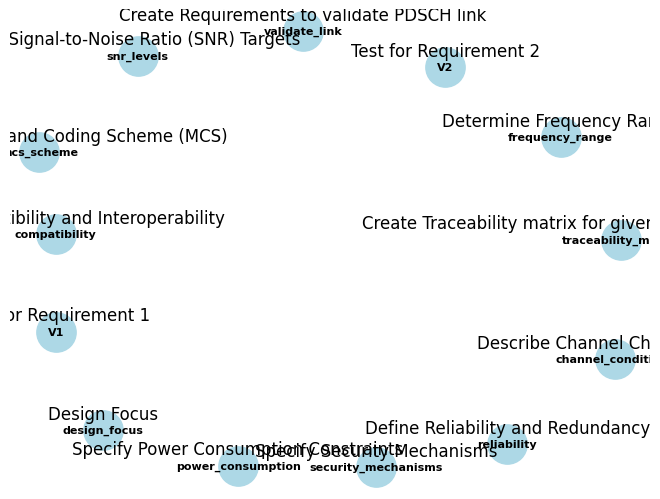

In [20]:
# Assuming you have pdsch_requirements and validation_tests dictionaries defined

# Create a directed graph
graph = nx.DiGraph()

# Add nodes for requirements
for requirement_id, requirement_info in pdsch_requirements.items():
    graph.add_node(requirement_id, label=requirement_info['description'])

# Define validation tests (replace with your actual tests)
validation_tests = {
    "V1": {"description": "Test for Requirement 1"},
    "V2": {"description": "Test for Requirement 2"},
    # Add more tests as needed
}

# Add nodes for validation tests
for test_id, test_info in validation_tests.items():
    graph.add_node(test_id, label=test_info['description'])

# Connect nodes based on traceability matrix
for requirement_id, requirement_info in pdsch_requirements.items():
    if 'linked_tests' in requirement_info:
        for test_id in requirement_info['linked_tests']:
            graph.add_edge(requirement_id, test_id)

# Draw the graph
pos = nx.spring_layout(graph, seed=42)

# Add space between nodes
pos_labels = {k: (v[0], v[1] + 0.07) for k, v in pos.items()}

# Draw dotted lines between nodes
edge_style = {"style": "dotted"}
nx.draw(graph, pos, with_labels=True,
        node_size=800, node_color='lightblue', font_size=8, font_color='black', font_weight='bold', arrowsize=10, connectionstyle='arc3,rad=0.1', edge_color='gray')

# Add labels to nodes
node_labels = nx.get_node_attributes(graph, 'label')
nx.draw_networkx_labels(graph, pos_labels, labels=node_labels)

# Show the graph
plt.show()

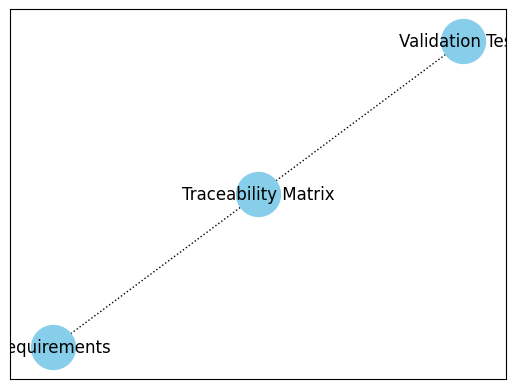

In [21]:
# Assuming you have a graph G and nodes and edges defined
G = nx.Graph()
nodes = ["Requirements", "Traceability Matrix", "Validation Tests"]
edges = [("Requirements", "Traceability Matrix"), ("Traceability Matrix", "Validation Tests")]

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Draw nodes
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=1000)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="black", style="dotted")

# Draw labels
nx.draw_networkx_labels(G, pos)

# Display the graph
plt.show()

In [ ]:
# Reference 
http://share.mathworks.com/925ad 